In [1]:
#imports
import logging
import torch
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression
import matplotlib.pyplot as plt

from sk_models import PLSRegression, StandardScaler,LocalWeightedRegression,PLSLWR,LinearRidge
from river_models import *

from river import stream,linear_model,preprocessing, ensemble, metrics, optim
from river.neighbors import KNNRegressor 
from sklearn.metrics import mean_squared_error
from river.utils import dict2numpy, numpy2dict

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and output directories

#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "PLN7.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =["db_id","sample_id"] #
output_cols = None
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/10.1") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\10.1\PLN7


In [3]:
data = pd.read_csv(data_file)
data=data.sample(frac=1,random_state=random_state)

pre_ind =[i for i in range(0,10000)]
pretrain_ind,pretest_ind = train_test_split(pre_ind,train_size=5/6,random_state=random_state,shuffle=False)
stream_ind = [i for i in range(10000,110000)]

pretrain_data =  ut.TabularDataset(data.iloc[pretrain_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
pretest_data = ut.TabularDataset(data.iloc[pretest_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
stream_data = ut.TabularDataset(data.iloc[stream_ind,:],id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)

nrow, ncol = data.shape
nrow_train = len(pretrain_data)
nrow_test = len(pretest_data)
nrow_stream = len(stream_data)

print(f"train: {nrow_train}, test: {nrow_test}, stream: {nrow_stream}")

train: 8333, test: 1667, stream: 100000


In [4]:
#deep, deep_lwr, ensemble_deep, deep_ensemble_lwr, ensemble_deep

pls_nums = ["random_82","random_24","random_10","random_4","random_73"]
deep_nums = ["random_29","random_60","random_63","random_41","random_15"]  #[13,57,77,60,76]

pls_model_dir = Path("D:/workspace/lazydeep/experiments/1.01/PLN7")
deep_model_dir = Path("D:/workspace/lazydeep/experiments/2.00/PLN7")

pls_scaler = PLSRegression(n_components=34).from_state(PLSRegression(n_components=34).load_state(pls_model_dir/'preprocessing'/f"_final"))      
deep_scaler = StandardScaler().from_state(StandardScaler().load_state(deep_model_dir/'preprocessing'/f"_final"))      

def build_model(dir_,id_,scaler_):
    deep_ = torch.load(dir_/"models"/id_/"_model")
    deep_.load_state(dir_/"models"/id_/"_final")
    
    return (StreamWrapper(scaler_)|StreamDeep(deep_))

def build_model_lwr(dir_,id_,scaler_,k_=1000):
    model = build_model(dir_,id_,scaler_)
    
    return (model|preprocessing.StandardScaler()|StreamLocalWeightedRegression(n_neighbors=k_,floor=True))



In [5]:
river_models = {}

river_models['E(pls-deep)'] =  VotingRegressor([build_model(pls_model_dir,i,pls_scaler) for i in pls_nums],record_diversity=True)
river_models['E(pls-deep-lwr)'] =  VotingRegressor([build_model_lwr(pls_model_dir,i,pls_scaler) for i in pls_nums],record_diversity=True)

river_models['E(std-deep)'] = VotingRegressor([build_model(deep_model_dir,i,deep_scaler) for i in deep_nums],record_diversity=True)
river_models['E(std-deep-lwr)'] =  VotingRegressor([build_model_lwr(deep_model_dir,i,deep_scaler) for i in deep_nums],record_diversity=True)


bags = {}
#build deep lwr models
for i,k in enumerate(pls_nums):
    bag = BaggingRegressor2(n_models=3,seed=seed,model = StreamLocalWeightedRegression(n_neighbors=1000,floor=True),record_diversity=True)
    bags[f'pls-deep{i}-E(lwr)']=bag
    river_models[f'pls-deep{i}-E(lwr)'] = (build_model(pls_model_dir,pls_nums[i],pls_scaler)|bag)

for i,k in enumerate(deep_nums):
    bag = BaggingRegressor2(n_models=3,seed=seed,model = StreamLocalWeightedRegression(n_neighbors=1000,floor=True),record_diversity=True)
    bags[f'std-deep{i}-E(lwr)']=bag
    river_models[f'std-deep{i}-E(lwr)'] = (build_model(deep_model_dir,deep_nums[i],deep_scaler)|bag)





#setup our metrics and stores of results
full_set = river_models.keys()
metrics = {'R2':{name:metrics.R2() for name in full_set},
           'R2_rolling':{name:RollingR2(window_size=1000) for name in full_set},
           'MSE':{name:metrics.MSE() for name in river_models.keys()},
           'MSE_rolling':{name:RollingMSE(window_size=1000) for name in full_set}
          }

In [6]:
full_set = river_models.keys()
metrics = {'R2':{name:metrics.R2() for name in full_set},
           'R2_rolling': {name:RollingR2(window_size=1000) for name in full_set},
           'MSE':{name:metrics.MSE() for name in river_models.keys()},
           'MSE_rolling':{name:RollingMSE(window_size=1000) for name in full_set}
          }

In [7]:
#take our pretrained models, now evaluate them on 

In [8]:
_,_,river_models,metrics = prequential_evaluate(pretrain_data,river_models,metrics,pretrain = len(pretrain_data),num_its=len(pretrain_data))

  0%|          | 0/8333 [00:00<?, ?it/s]

In [9]:
preds_test,scores_test,metrics = score_evaluate(pretest_data,river_models,metrics,num_its=len(pretest_data))

  0%|          | 0/1667 [00:00<?, ?it/s]

In [10]:
preds_stream, scores_stream,river_models,metrics = prequential_evaluate(stream_data,river_models,metrics,pretrain=0,num_its=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
def zip_dict(dict1,dict2):
 
    dict12 = {k:dict1[k]+dict2[k] for k in dict1.keys()}   
    return dict12

def zip_nested_dict(dict1,dict2):
    dict12 = {}
    
    for k in dict1.keys():
        dict12[k] = {name:dict1[k][name]+dict2[k][name] for name in dict1[k].keys()}
    return dict12

In [12]:
preds = zip_dict(preds_test,preds_stream)

In [13]:
scores = zip_nested_dict(scores_test,scores_stream)

In [14]:
preds_df = pd.DataFrame(preds)

for (columnName, columnData) in preds_df.iteritems():
    preds_df[f'diff_{columnName}'] = columnData-preds_df['y']

preds_df.to_csv(log_dir/"preds_df.csv")

In [15]:
#findings
#1) preprocessing works, random lr things for lr don't
#) standardisation asks as regularisation

scores_df_rolling = pd.DataFrame(scores['R2_rolling'])
scores_df_total = pd.DataFrame(scores['R2'])

scores_df_rolling.to_csv(log_dir/"R2_rolling.csv")
scores_df_total.to_csv(log_dir/"R2.csv")

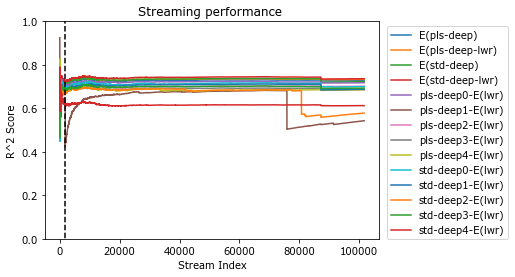

In [16]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance ")

for (columnName, columnData) in scores_df_total.iteritems():
    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2.png",bbox_inches='tight')


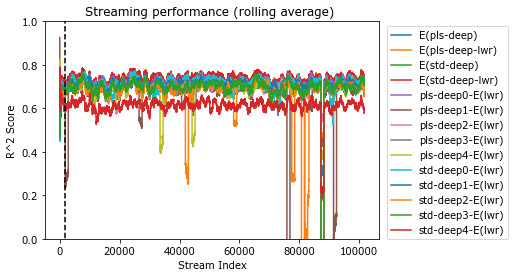

In [17]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R^2 Score")
ax.set_title("Streaming performance (rolling average) ")
    
for (columnName, columnData) in scores_df_rolling.iteritems():
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2.png",bbox_inches='tight')

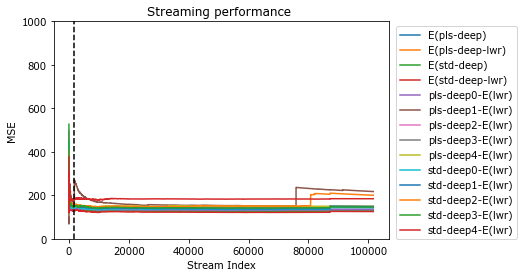

In [18]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance ")

scores_df = pd.DataFrame(scores['MSE'])
scores_df.to_csv(log_dir/"MSE.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,'-',label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[0,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot.png",bbox_inches='tight')
ax.set_ylim(0,1000)
plt.savefig(log_dir / f"mse_plot_v2.png",bbox_inches='tight')

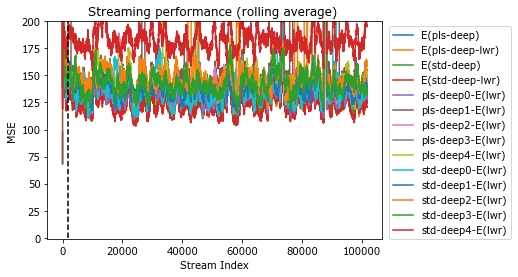

In [19]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("MSE")
ax.set_title("Streaming performance (rolling average) ")

scores_df = pd.DataFrame(scores['MSE_rolling'])
scores_df.to_csv(log_dir/"MSE_rolling.csv")
for (columnName, columnData) in scores_df.iteritems():
    ax.plot(columnData.index,columnData,label = f"{columnName}")
ax.plot([len(pretest_data),len(pretest_data)],[0,1000],c="black",ls='--')
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_rolling.png",bbox_inches='tight')
ax.set_ylim(-1,200)
plt.savefig(log_dir / f"mse_plot_rolling_v2.png",bbox_inches='tight')

E(pls-deep), p = 0.853315712853561, MSE = 129.59971992723644, R2 = 0.7273632556886866
E(pls-deep-lwr), p = 0.8560372594320261, MSE = 127.05887309339836, R2 = 0.732708392305959
E(std-deep), p = 0.8503077194532722, MSE = 131.95784593591986, R2 = 0.7224025057885769
E(std-deep-lwr), p = 0.8586153423867506, MSE = 125.36113282204424, R2 = 0.7362798998719327
pls-deep0-E(lwr), p = 0.8473922895770251, MSE = 134.2032084345338, R2 = 0.7176789745821475
pls-deep1-E(lwr), p = 0.758906606364105, MSE = 217.29935018706865, R2 = 0.542871023106927
pls-deep2-E(lwr), p = 0.8378382571568026, MSE = 141.83638086729837, R2 = 0.701621198515932
pls-deep3-E(lwr), p = 0.8286376967333817, MSE = 149.242344220515, R2 = 0.6860413983570772
pls-deep4-E(lwr), p = 0.8286985970415206, MSE = 149.55695554814048, R2 = 0.6853795558150145
std-deep0-E(lwr), p = 0.8380175717216662, MSE = 142.51370268383351, R2 = 0.7001963280377023
std-deep1-E(lwr), p = 0.8300441363218181, MSE = 148.2131826175909, R2 = 0.6882064282579828
std-deep2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(0.0, 500.0)

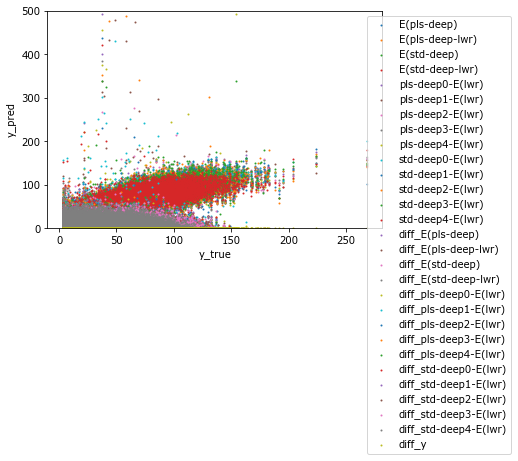

In [29]:
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

fig, ax = plt.subplots()
ax.set_ylabel('y_pred')
ax.set_xlabel('y_true')

for (columnName, columnData) in preds_df.iteritems():
        if not columnName == 'y':
            ax.scatter(preds_df['y'],columnData,label = f"{columnName}",s=1)
            
            corr_coef = scipy.stats.pearsonr(columnData, preds_df['y'])
            r2 = r2_score(preds_df['y'],columnData)
            #slope, intercept, r, p, stderr = scipy.stats.linregress(columnData, preds_df['y'])
            loss = mean_squared_error(preds_df['y'], columnData)
            mae = mean_absolute_error(preds_df['y'], columnData)    
            print(f"{columnName}, p = {corr_coef[0]}, MSE = {loss}, R2 = {r2}")
            
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylim(0,500)

In [21]:
def take_subset_by_str(dataset,s,reverse=False):
    col_names = dataset.columns.tolist()
    if reverse:
        encoding = [i for i in col_names if not (s in i)]
    else:
        encoding = [i for i in col_names if (s in i)]
    return dataset[encoding]

def take_subset_by_re(dataset,s,reverse=False):
    col_names = dataset.columns.tolist()
    if reverse:
        encoding = [i for i in col_names if not s.match(i)]
    else:
        encoding = [i for i in col_names if s.match(i)]
    return dataset[encoding]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[101666 rows x 0 columns]


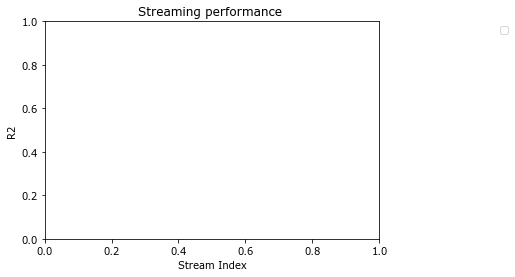

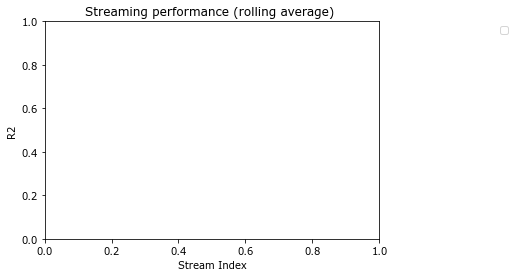

In [ ]:
# std-deep-lwr subset

p = re.compile('(std-deep_\d-lwr)')
subset = take_subset_by_re(scores_df_total ,p,reverse=False)
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance ")


for (columnName, columnData) in subset.iteritems():
    ax.plot(columnData.index,columnData,label =  f"{columnName}")
#ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_std-deep-lwr.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2_std-deep-lwr.png",bbox_inches='tight')


subset = take_subset_by_re(scores_df_rolling ,p,reverse=False)
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance (rolling average) ")

for (columnName, columnData) in subset.iteritems():
    ax.plot(columnData.index,columnData,label =  f"{columnName}")
#ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling_std-deep-lwr.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2_std-deep-lwr.png",bbox_inches='tight')


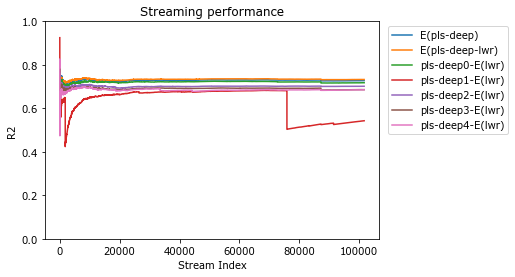

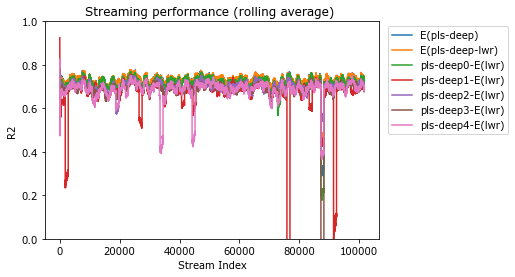

In [23]:
# pls ensembles

subset = take_subset_by_str(scores_df_total ,'pls',reverse=False)
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance")

for i,((columnName, columnData)) in enumerate(subset.iteritems()):
    #if i == 0 or i==1:
        ax.plot(columnData.index,columnData,label =  f"{columnName}")
#ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pls-ensemble.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2_pls-ensemble.png",bbox_inches='tight')

subset = take_subset_by_str(scores_df_rolling ,'pls',reverse=False)
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance (rolling average) ")

for i,((columnName, columnData)) in enumerate(subset.iteritems()):
    #if i == 0 or i==1:
        ax.plot(columnData.index,columnData,label =  f"{columnName}")
#ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling_pls-ensemble.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2_pls-ensemble.png",bbox_inches='tight')

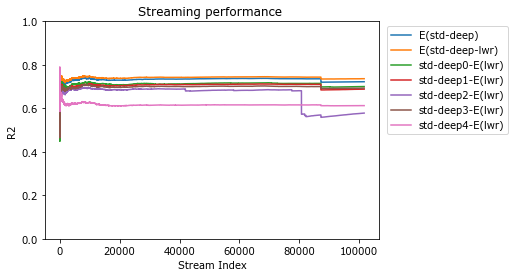

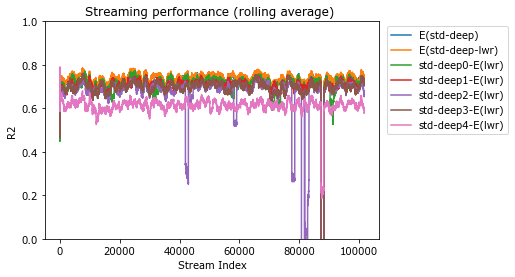

In [24]:
# std ensembles

subset = take_subset_by_str(scores_df_total ,'std',reverse=False)
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance ")


for i,((columnName, columnData)) in enumerate(subset.iteritems()):
    #if i == 0 or i==1:
        ax.plot(columnData.index,columnData,label =  f"{columnName}")
#ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_std-ensemble.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2_std-ensemble.png",bbox_inches='tight')

subset = take_subset_by_str(scores_df_rolling ,'std',reverse=False)
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel("R2")
ax.set_title("Streaming performance (rolling average) ")


for i,((columnName, columnData)) in enumerate(subset.iteritems()):
    #if i == 0 or i==1:
        ax.plot(columnData.index,columnData,label =  f"{columnName}")
#ax.plot([len(pretest_data),len(pretest_data)],[-1,1],c="black",ls='--')

ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_rolling_std-ensemble.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2_std-ensemble.png",bbox_inches='tight')

In [25]:
#id1 = 87217-len(pretest_data)
#x1,y1=stream_data[id1]
#river_models[f'std-deep_0'].predict_one(numpy2dict(x1))

KeyError: 'std-deep_0'

In [26]:
for k in river_models.keys():
    print(k)
    if k in bags.keys():
        print(bags[k].measure_diversity())
    else:
        print(river_models[k].measure_diversity())



E(pls-deep)
          0         1         2         3         4         v
0  1.000000  0.956635  0.942445  0.951543  0.956401  0.983977
1  0.956635  1.000000  0.921598  0.947193  0.942512  0.974050
2  0.942445  0.921598  1.000000  0.924994  0.932360  0.960611
3  0.951543  0.947193  0.924994  1.000000  0.952216  0.975641
4  0.956401  0.942512  0.932360  0.952216  1.000000  0.977269
v  0.983977  0.974050  0.960611  0.975641  0.977269  1.000000
E(pls-deep-lwr)
          0         1         2         3         4         v
0  1.000000 -0.004525  0.355374  0.950564  0.438305  0.981825
1 -0.004525  1.000000 -0.001102 -0.006189 -0.001974 -0.004343
2  0.355374 -0.001102  1.000000  0.350223  0.161365  0.362965
3  0.950564 -0.006189  0.350223  1.000000  0.438223  0.975242
4  0.438305 -0.001974  0.161365  0.438223  1.000000  0.449997
v  0.981825 -0.004343  0.362965  0.975242  0.449997  1.000000
E(std-deep)
          0         1         2         3         4         v
0  1.000000  0.929262  0.91061